# **Получение эмбеддингов для пользователей и фильмов из датасета MovieLens (full) и использованием нейросетевого подхода**

[Датасет](https://grouplens.org/datasets/movielens/latest/) состоит из: 27 000 000 оценок и 1 100 000 применений тегов, примененных к 58 000 фильмов 280 000 пользователями. Включает данные генома тегов с 14 миллионами оценок релевантности по 1 100 тегам. Последнее обновление 9/2018.

В первой и второй части данной работы выполнена первичная подготовка датасета **MovieLens (full)**, а также визуализация закономерностей и зависимостей данных, проведен анализ результатов.

Во второй части работы выполнено разбиение датасета на тестовую и валидационную части, реализован `DataLoader` для этих частей, написана архитектура нейронной сети на фреймворке PyTorch, а также выполнено обучение и валидация модели.

В завершающей, третьей части, произведен вывод полученных векторных представлений (эмбеддингов), а также небольшая демонстрация работы рекомендационного алгоритма.

## **1. Импорт библиотек и загрузка датасета, первичная подготовка**

In [6]:
import os
import re
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, notebook
from datetime import datetime, date, time
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns
import random

import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
display(device)

device(type='cuda')

In [8]:
DATA_DIR='data'
#! wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/
! wget https://files.grouplens.org/datasets/movielens/ml-latest.zip -P data/
! unzip data/ml-latest.zip -d data/

--2023-05-09 00:02:36--  https://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘data/ml-latest.zip’

ml-latest.zip       100%[===================>] 264.28M  56.6MB/s    in 5.0s    

2023-05-09 00:02:41 (53.0 MB/s) - ‘data/ml-latest.zip’ saved [277113433/277113433]

Archive:  data/ml-latest.zip
   creating: data/ml-latest/
  inflating: data/ml-latest/links.csv  
  inflating: data/ml-latest/tags.csv  
  inflating: data/ml-latest/genome-tags.csv  
  inflating: data/ml-latest/ratings.csv  
  inflating: data/ml-latest/README.txt  
  inflating: data/ml-latest/genome-scores.csv  
  inflating: data/ml-latest/movies.csv  


In [9]:
path = '/content/data/ml-latest/'

links = pd.read_csv(path + 'links.csv', index_col='movieId', dtype={'imdbId': np.int32})
movies = pd.read_csv(path + 'movies.csv', index_col='movieId')
ratings = pd.read_csv(path + 'ratings.csv', parse_dates=["timestamp"], dtype={'userId': np.int32, 'movieId': np.int32, 'rating': np.float32})
tags = pd.read_csv(path + 'tags.csv', parse_dates=["timestamp"], dtype={'userId': np.int32, 'movieId': np.int32, 'tagId': np.int16})
genome_scores = pd.read_csv(path + 'genome-scores.csv', dtype={'movieId': np.int32, 'tagId': np.int16, 'relevance': np.float32})
genome_tags = pd.read_csv(path + 'genome-tags.csv', index_col='tagId')

In [10]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

In [11]:
print('links', links.shape)
display(links.head())
print('movies', movies.shape)
display(movies.head())
print('ratings', ratings.shape)
display(ratings.head())
print('tags', tags.shape)
display(tags.head())
print('genome_scores', genome_scores.shape)
display(genome_scores.head())
print('genome_tags', genome_tags.shape)
display(genome_tags.head())

links (58098, 2)


,imdbId,tmdbId
movieId,,
1,114709,862.0
2,113497,8844.0
3,113228,15602.0
4,114885,31357.0
5,113041,11862.0


movies (58098, 2)


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


ratings (27753444, 4)


,userId,movieId,rating,timestamp
0,1,307,3.5,2009-10-27 21:00:21
1,1,481,3.5,2009-10-27 21:04:16
2,1,1091,1.5,2009-10-27 21:04:31
3,1,1257,4.5,2009-10-27 21:04:20
4,1,1449,4.5,2009-10-27 21:01:04


tags (1108997, 4)


,userId,movieId,tag,timestamp
0,14,110,epic,2015-09-25 02:35:38
1,14,110,Medieval,2015-09-25 02:35:32
2,14,260,sci-fi,2015-09-13 18:36:50
3,14,260,space action,2015-09-13 18:37:01
4,14,318,imdb top 250,2015-09-18 22:26:35


genome_scores (14862528, 3)


,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000


genome_tags (1128, 1)


,tag
tagId,
1,007
2,007 (series)
3,18th century
4,1920s
5,1930s


In [12]:
print('links:')
print(links.isna().sum())
print('\nmovies:')
print(movies.isna().sum())
print('\nratings:')
print(ratings.isna().sum())
print('\ntags:')
print(tags.isna().sum())
print('\ngenome_scores:')
print(genome_scores.isna().sum())
print('\ngenome_tags:')
print(genome_tags.isna().sum())

links:
imdbId      0
tmdbId    181
dtype: int64

movies:
title     0
genres    0
dtype: int64

ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

tags:
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

genome_scores:
movieId      0
tagId        0
relevance    0
dtype: int64

genome_tags:
tag    0
dtype: int64


In [13]:
links['tmdbId'] = links['tmdbId'].dropna()
links.head()

,imdbId,tmdbId
movieId,,
1,114709,862.0
2,113497,8844.0
3,113228,15602.0
4,114885,31357.0
5,113041,11862.0


## **2. Визуализация и анализ данных**

In [14]:
print(ratings['userId'].nunique(), ratings['movieId'].nunique())
print('\n')
print(np.round(ratings['rating'].describe(), 2))

283228 53889


count    27753444.00
mean            3.53
std             1.07
min             0.50
25%             3.00
50%             3.50
75%             4.00
max             5.00
Name: rating, dtype: float64


In [15]:
unique_genres = []
for index, row in tqdm(movies.iterrows(), total=len(movies)):
    genres_list = row['genres'].split('|')
    for genre in genres_list:
        if genre not in unique_genres:
            unique_genres.append(genre)
            
print(unique_genres)
print('\n Количество уникальных жанров:', len(unique_genres))

100%|██████████| 58098/58098 [00:04<00:00, 14308.26it/s]

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir', '(no genres listed)']

 Количество уникальных жанров: 20


In [16]:
ids_genres = [[] for _ in np.arange(20)]
for (id, row) in tqdm(movies.iterrows(), total=movies.shape[0]):
    for i, genre in enumerate(unique_genres):
        if genre in row[1]:
            ids_genres[i].append(id)

results = []
for i, id in enumerate(ids_genres):
    grp = ratings.groupby('movieId')['rating'].mean()
    genre_mean = grp[grp.index.isin(id)].mean().round(2)
    results.append([list(unique_genres)[i], genre_mean])

df = pd.DataFrame(results, columns=['Genre', 'Mean Rating'])
display(df.sort_values(by='Mean Rating', ascending=False))

100%|██████████| 58098/58098 [00:07<00:00, 7415.79it/s]


,Genre,Mean Rating
14,Documentary,3.40
18,Film-Noir,3.31
13,IMAX,3.26
15,War,3.24
16,Musical,3.20
6,Drama,3.18
5,Romance,3.15
1,Animation,3.10
8,Crime,3.08
3,Comedy,3.05


In [17]:
years = set()
for title in movies['title']:
    match = re.search(r'\((\d{4})\)', title)
    if match:
        years.add(int(match.group(1)))

unique_years = sorted(list(years))
print(unique_years)

[1874, 1878, 1883, 1887, 1888, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [18]:
years = unique_years
ids_years = [[] for _ in np.arange(len(years))]
for (id, row) in tqdm(movies.iterrows(), total=movies.shape[0]):
    for i, year in enumerate(years):
        if str(year) in row[0]:
            ids_years[i].append(id)

results = []
for i, id in enumerate(ids_years):
    grp = ratings.groupby('movieId')['rating'].mean()
    year_mean = grp[grp.index.isin(id)].mean().round(2)
    results.append([years[i], year_mean])

df = pd.DataFrame(results, columns=['Year', 'Mean Rating'])
display(df.sort_values(by='Mean Rating', ascending=False))

100%|██████████| 58098/58098 [00:16<00:00, 3493.09it/s]


,Year,Mean Rating
39,1924,3.36
43,1928,3.34
41,1926,3.33
26,1911,3.31
38,1923,3.30
...,...,...
5,1890,1.82
3,1887,1.78
4,1888,1.71
6,1891,1.38


Чтобы показать, что для каждого пользователя действительно своя средняя оценка, можно построить box plot для средних оценок каждого пользователя. В этом случае, если для каждого пользователя существует своя средняя оценка, то box plot должен иметь достаточно большое количество выбросов.

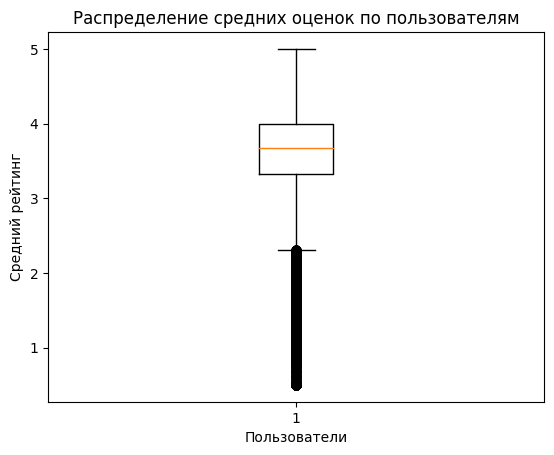

In [19]:
user_mean_ratings = ratings.groupby('userId')['rating'].mean()
#user_mean_ratings = user_mean_ratings[user_mean_ratings.between(user_mean_ratings.quantile(.05), user_mean_ratings.quantile(.95))]

plt.boxplot(user_mean_ratings)
plt.xlabel('Пользователи')
plt.ylabel('Средний рейтинг')
plt.title('Распределение средних оценок по пользователям')
plt.show()

Действительно, у каждого пользователя своя средняя оценка и распределение имеет много выбросов, что свидетельствует о том, что модель на основе, например,  Collaborative filtering, могла бы показать хорошие результаты, так как учитывает индивидуальные предпочтения пользователей.

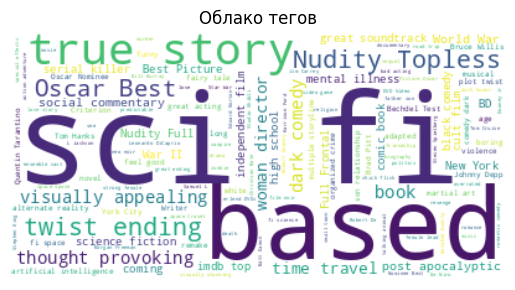

In [20]:
tags_text = ' '.join(tags['tag'].fillna(''))
wordcloud = WordCloud(background_color='white').generate(tags_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Облако тегов')
plt.show()

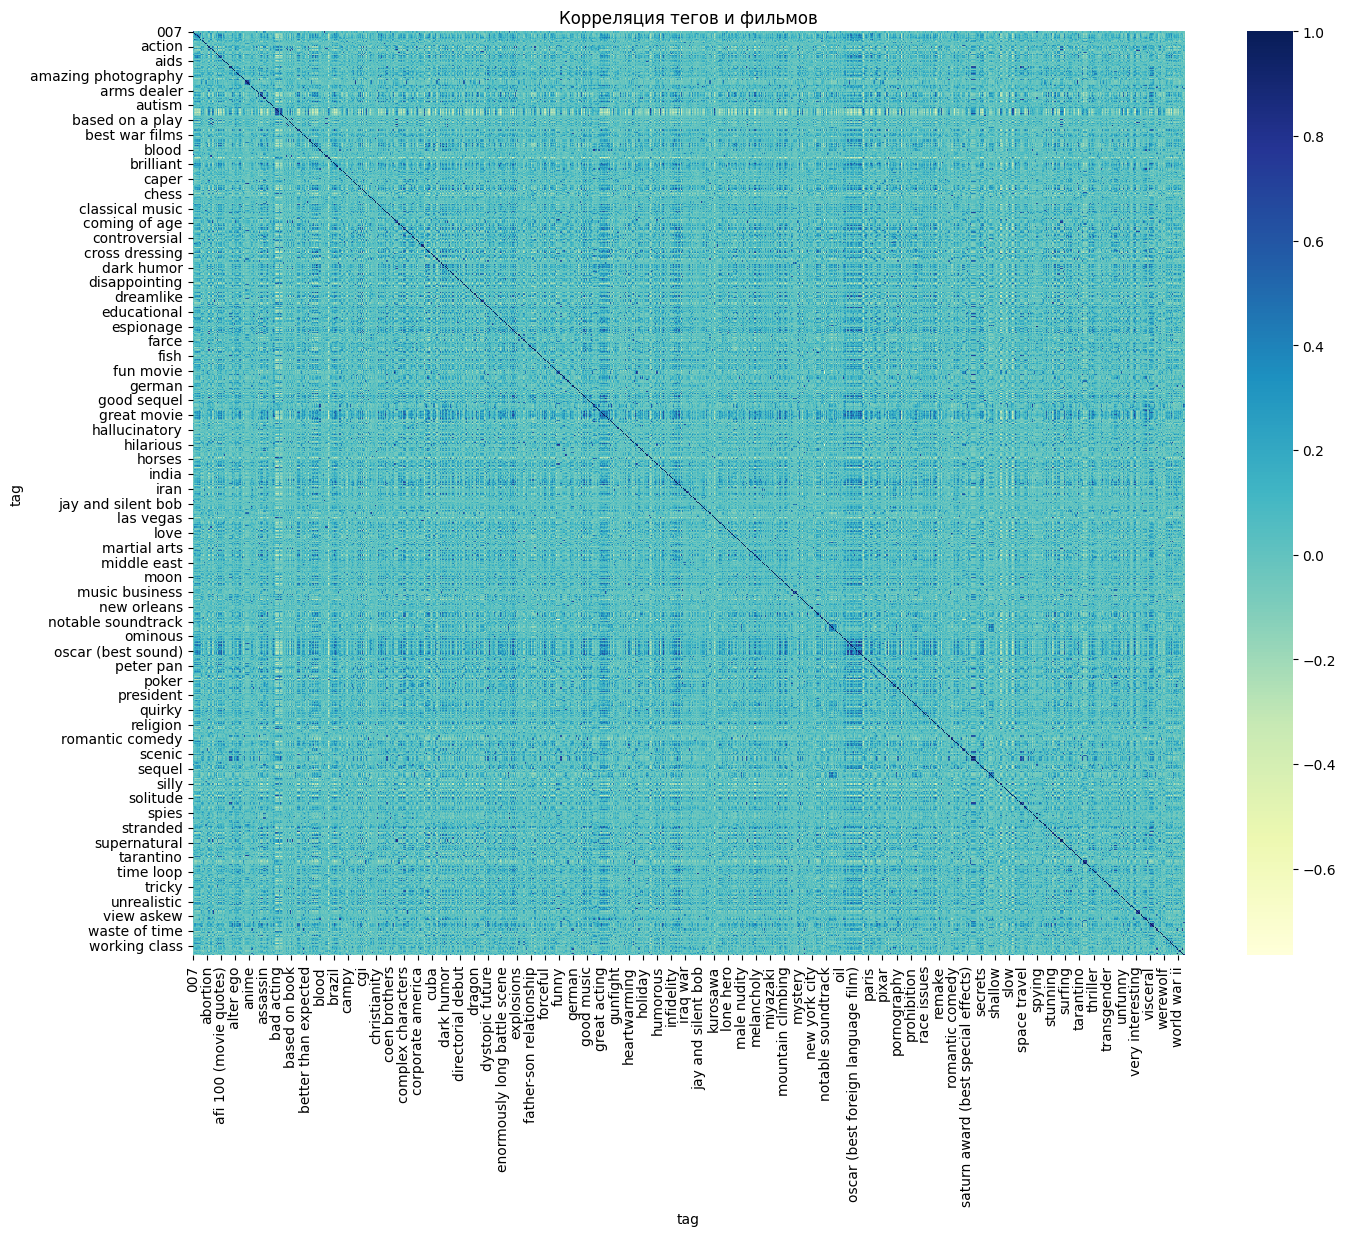

In [21]:
genome_scores_tags = pd.merge(genome_scores, genome_tags, on='tagId')
genome_pivot = genome_scores_tags.pivot_table(index='movieId', columns='tag', values='relevance')

plt.figure(figsize=(16, 12))
sns.heatmap(genome_pivot.corr(), cmap="YlGnBu")
plt.title('Корреляция тегов и фильмов')
plt.show()

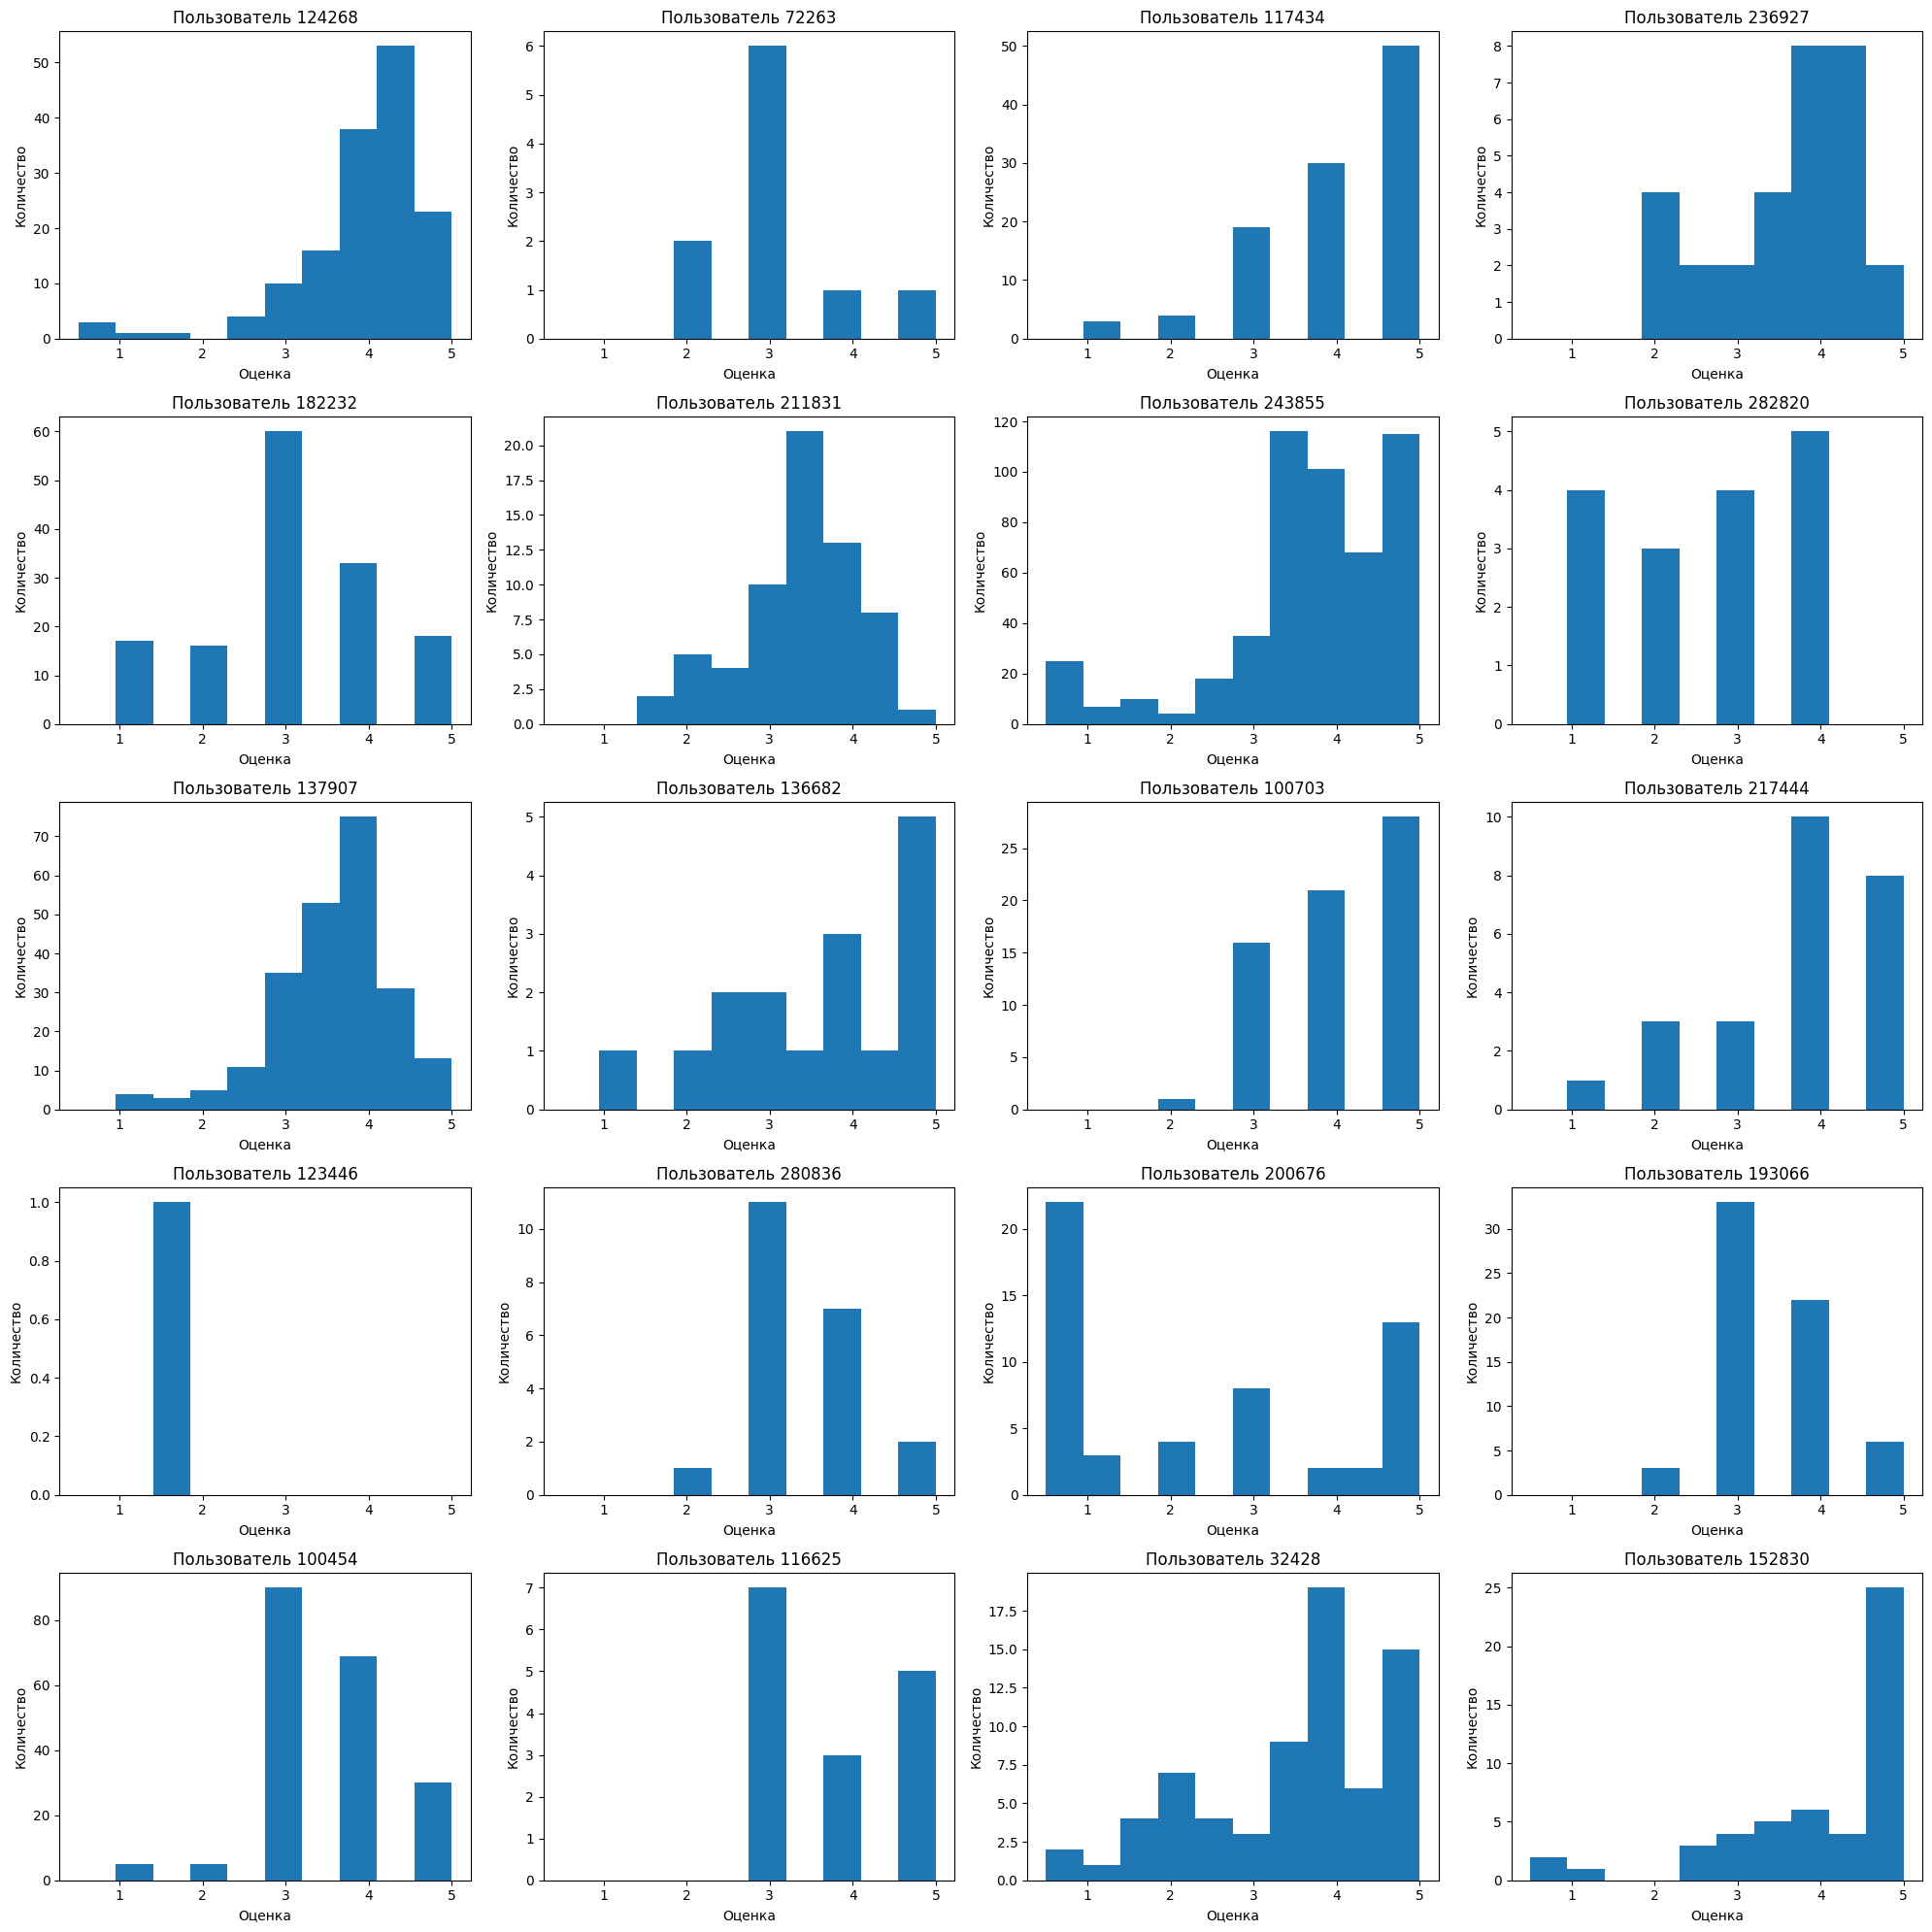

In [22]:
users = ratings['userId'].unique()
random_users = random.sample(list(users), 20)

plt.figure(figsize=(20, 20))
for i, user in enumerate(random_users):
    user_ratings = ratings[ratings['userId'] == user]['rating']
    plt.subplot(5, 4, i+1)
    plt.hist(user_ratings, bins=10, range=(0.5, 5.0))
    plt.xlabel('Оценка')
    plt.ylabel('Количество')
    plt.title(f'Пользователь {user}')
    
plt.tight_layout()
plt.show()

Из гистограмм выше мы видим, что для каждого пользователя характерно свое распределение оценок.

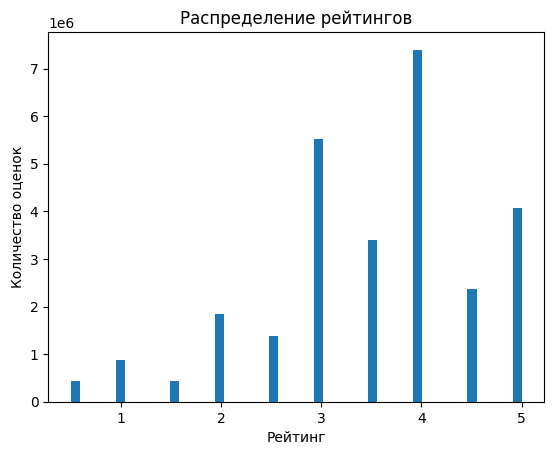

In [23]:
plt.hist(ratings['rating'], bins=50)
plt.xlabel('Рейтинг')
plt.ylabel('Количество оценок')
plt.title('Распределение рейтингов')
plt.show()

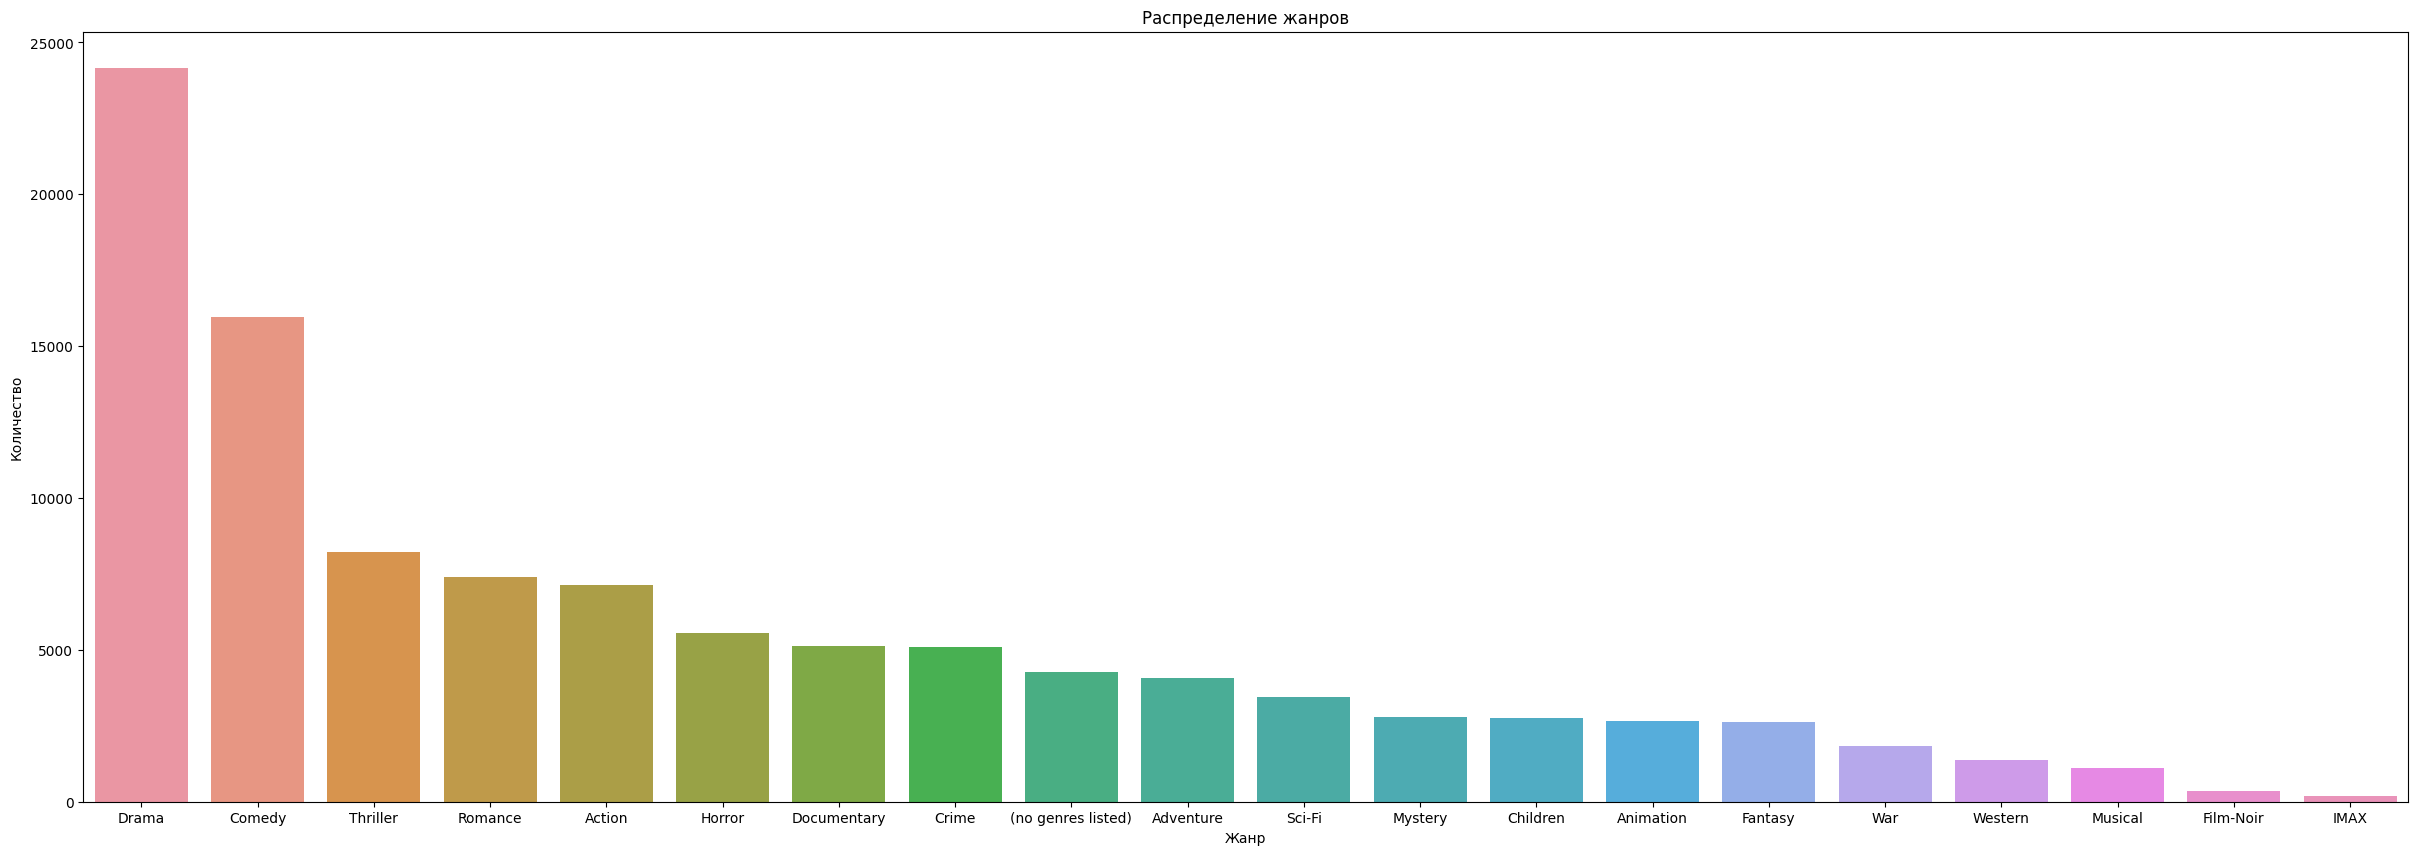

In [27]:
genres = movies['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True)
genres.name = 'genre'

genre_count = genres.value_counts()

plt.figure(figsize=(30, 10))
sns.barplot(x=genre_count.index, y=genre_count.values)

plt.title("Распределение жанров")
plt.xlabel("Жанр")
plt.ylabel("Количество")

plt.show()

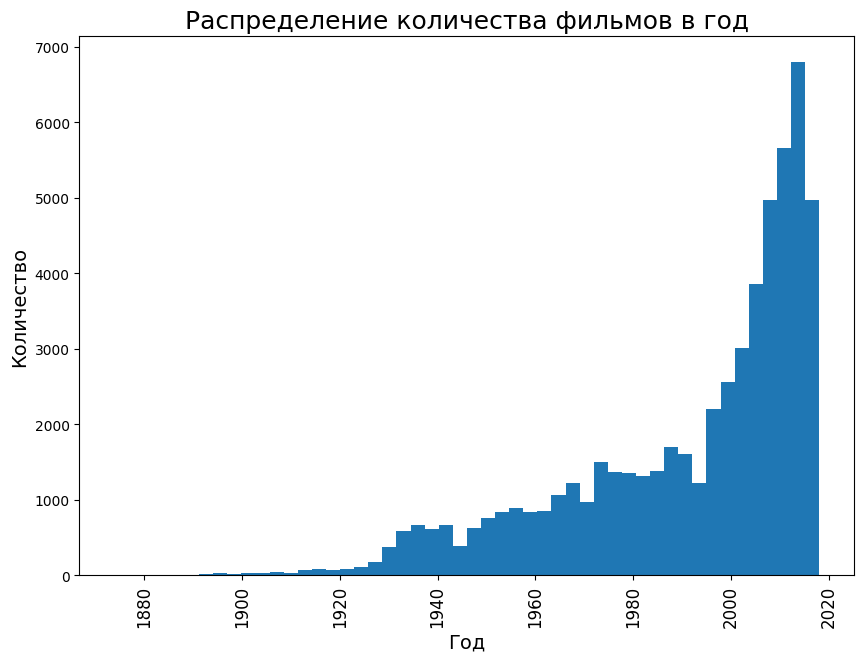

In [28]:
movies['year'] = np.float32(movies['title'].str.extract(r'\((\d{4})\)', expand=False))
movies_year_count = movies.groupby(['year'])['title'].count()

plt.figure(figsize=(10, 7))
plt.hist(movies['year'], bins=50)

plt.title("Распределение количества фильмов в год", fontsize=18)
plt.xlabel("Год", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel("Количество", fontsize=14)
movies = movies.drop('year', axis=1)
plt.show()

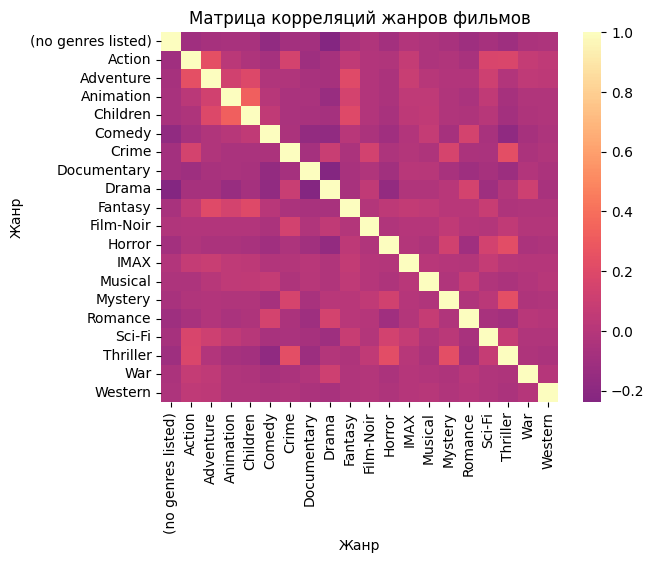

In [26]:
genres = movies['genres'].str.get_dummies(sep='|')
corr_matrix = genres.corr(method='pearson')
sns.heatmap(corr_matrix, cmap='magma', center=0)
plt.title('Матрица корреляций жанров фильмов')
plt.xlabel('Жанр')
plt.ylabel('Жанр')

plt.show()

## **3. Нейросеть**

### **3.1. Train/Test Loader**

In [29]:
ratings = pd.read_csv(path + 'ratings.csv', parse_dates=["timestamp"], dtype={'userId': np.int32, 'movieId': np.int32, 'rating': np.float32})
ratings_sample = ratings.copy()
ratings_sample['rating'] = (ratings['rating'] - ratings['rating'].mean()) / (ratings['rating'].max() - ratings['rating'].min())

train_ratings, test_ratings = train_test_split(ratings_sample, test_size=0.2)

# Создание словаря для сопоставления идентификаторов пользователей и фильмов с индексами строк
user_id_to_index = {id: i for i, id in tqdm(enumerate(train_ratings['userId'].unique()), total=len(train_ratings['userId'].unique()))}
movie_id_to_index = {id: i for i, id in tqdm(enumerate(train_ratings['movieId'].unique()), total=len(train_ratings['movieId'].unique()))}

train_ratings['user_row'] = train_ratings['userId'].apply(lambda id: user_id_to_index[id])
train_ratings['movie_row'] = train_ratings['movieId'].apply(lambda id: movie_id_to_index[id])
test_ratings['user_row'] = test_ratings['userId'].apply(lambda id: user_id_to_index.get(id, -1))
test_ratings['movie_row'] = test_ratings['movieId'].apply(lambda id: movie_id_to_index.get(id, -1))

100%|██████████| 51558/51558 [00:00<00:00, 2193849.36it/s]


In [30]:
# Удаление строк с неизвестными пользователями или фильмами из набора данных для тестирования
test_ratings = test_ratings[(test_ratings['user_row'] >= 0) & (test_ratings['movie_row'] >= 0)]

train_dataset = TensorDataset(torch.tensor(train_ratings['user_row'].values, dtype=torch.long),
                              torch.tensor(train_ratings['movie_row'].values, dtype=torch.long),
                              torch.tensor(train_ratings['rating'].values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_ratings['user_row'].values, dtype=torch.long),
                             torch.tensor(test_ratings['movie_row'].values, dtype=torch.long),
                             torch.tensor(test_ratings['rating'].values, dtype=torch.float32))

embedding_dim = 64
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### **3.2. Архитектура**

Данная архитектура представляет собой модель для рекомендательной системы, которая принимает на вход идентификаторы пользователей и фильмов и генерирует оценку релевантности для каждой пары.

Архитектура состоит из трех основных блоков:

Эмбеддинги пользователей и товаров: `nn.Embedding(num_users, emb_dim)` и `nn.Embedding(num_items, emb_dim)` соответственно. Эмбеддинги - это отображения каждого пользователя и товара в низкоразмерное пространство признаков `emb_dim`.

Несколько полносвязных слоев с активацией ReLU и пакетной нормализацией:`nn.Linear`, `nn.ReLU()`, `nn.BatchNorm1d` и `nn.Dropout`. Все слои, кроме последнего, имеют размерность, равную `emb_dim * 2`, так как для каждой пары пользователя и товара мы объединяем их эмбеддинги в один вектор признаков.

Выходной слой: `nn.Linear(hidden_sizes[-1], 1)` - вычисляет итоговую оценку релевантности для каждой пары пользователя и товара.

Функция `forward` берет на вход id пользователей и товаров, получает их эмбеддинги и объединяет их в один вектор признаков. Затем этот вектор пропускается через все полносвязные слои, последний из которых вычисляет окончательную оценку релевантности. Функция `l2_regularization` вычисляет L2-регуляризацию для всех параметров модели и добавляет ее к общей потере во время обучения для предотвращения переобучения.

Параметры:

* `num_users`: количество пользователей в наборе данных
* `num_items`: количество товаров в наборе данных
* `emb_dim`: размерность эмбеддингов для пользователей и товаров
* `hidden_sizes`: список размерностей скрытых слоев между входом и выходом
* `dropout_prob`: вероятность dropout для пакетной нормализации
* `l2_reg`: коэффициент регуляризации L2.

In [31]:
class EmbeddingNet(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, hidden_sizes=[128, 64, 32], dropout_prob=0.5, l2_reg=0.01):
        super(EmbeddingNet, self).__init__()
        
        self.user_embedding = nn.Embedding(num_users, emb_dim)
        self.item_embedding = nn.Embedding(num_items, emb_dim)

        layer_sizes = [emb_dim * 2] + hidden_sizes
        
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(layer_sizes[i + 1]))
            self.layers.append(nn.Dropout(p=dropout_prob))

        self.output_layer = nn.Linear(hidden_sizes[-1], 1)
        
        self.l2_reg = l2_reg

    def forward(self, user_indices, item_indices):
        user_emb = self.user_embedding(user_indices)
        item_emb = self.item_embedding(item_indices)
        x = torch.cat([user_emb, item_emb], dim=1)
        
        for layer in self.layers:
            x = layer(x)

        x = self.output_layer(x)
        
        return x.squeeze()

    def l2_regularization(self):
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.norm(param)
        return self.l2_reg * reg_loss

### **3.3. Обучение и валидация**

В данной реализации используется Mean Squared Error (MSE) как функция потерь, потому что это распространенная метрика для задач регрессии. MSE лосс максимизирует точность модели в предсказании рейтинга пользователя для каждого фильма.

In [32]:
!nvidia-smi

Tue May  9 00:11:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [216]:
num_users = len(train_ratings['userId'].unique())
num_movies = len(train_ratings['movieId'].unique())
embedding_net = EmbeddingNet(num_users, num_movies, embedding_dim, hidden_sizes=[128, 64, 32], dropout_prob=0.5, l2_reg=0.005).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(embedding_net.parameters(), lr=0.0034)

num_epochs = 1
train_loss_history = []
test_loss_history = []
best_test_loss = float('inf')

for epoch in tqdm(range(num_epochs), colour="GREEN"):
    train_loss = 0.0
    test_loss = 0.0
    
    # Training loop
    embedding_net.train()
    for batch in notebook.tqdm(train_loader, total=len(train_loader), colour="MAGENTA"):
        user_indices, item_indices, ratings = [x.to(device) for x in batch]
        
        optimizer.zero_grad()

        predicted_ratings = embedding_net(user_indices, item_indices)
        loss = criterion(predicted_ratings, ratings)
        loss += embedding_net.l2_regularization()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Testing loop
    embedding_net.eval()
    with torch.no_grad():
        for batch in notebook.tqdm(test_loader, total=len(test_loader), colour="BLUE"):
            user_indices, item_indices, ratings = [x.to(device) for x in batch]

            predicted_ratings = embedding_net(user_indices, item_indices)
            loss = criterion(predicted_ratings, ratings)

            test_loss += loss.item()
            
    train_loss = train_loss / len(train_loader)
    test_loss = test_loss / len(test_loader)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Сохранение модели, если ошибка при валидации уменьшилась
    if test_loss < best_test_loss:
        torch.save(embedding_net.state_dict(), 'best_model.pth')
        best_test_loss = test_loss

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/86730 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.1640, Test Loss: 0.0562


100%|██████████| 1/1 [26:56<00:00, 1616.87s/it]


## **4. Результаты**

### **4.1. Эмбеддинги**

In [221]:
item_embeddings = embedding_net.item_embedding.weight.data.cpu().numpy()
user_embeddings = embedding_net.user_embedding.weight.data.cpu().numpy()

In [222]:
print(item_embeddings.shape, user_embeddings.shape)

(51489, 64) (281897, 64)


### **4.2. Рекомендации фильмов**

In [223]:
user_to_index = {}
for i, user in enumerate(ratings_sample['userId']):
    user_to_index[user] = i

movie_to_index = {}
for i, movie in enumerate(movies.index):
    movie_to_index[movie] = i

In [296]:
def recommend_movies(embedding_net, user_embedding, item_embeddings, top_n=20):
    # Вычисление косинусного сходства между эмбеддингами пользователя и всеми эмбеддингами фильмов
    cos_sim = np.dot(item_embeddings, user_embedding) / (np.linalg.norm(item_embeddings, axis=1) * np.linalg.norm(user_embedding))

    movie_indices = np.argsort(cos_sim)[-top_n:][::-1]

    return movie_indices

def display_recommended_movies(inp):
    user_embedding = embedding_net.user_embedding.weight.data[inp].cpu().numpy()
    recommended_movies = recommend_movies(embedding_net, user_embedding, item_embeddings, top_n=20)

    rec_names = []
    rec_genres = []

    for i in recommended_movies:
        if i in movies.index:
            rec_names.append(movies.loc[i].values[0])
            rec_genres.append(movies.loc[i].values[1])

    df = pd.DataFrame({'Movie Title': rec_names, 'Genre': rec_genres})

    print('User:', inp)
    display(df)

def find_similar_movies(movie_embedding, item_embeddings, movie_to_index, top_n=20):
    similarities = np.dot(item_embeddings, movie_embedding) / (np.linalg.norm(item_embeddings, axis=1) * np.linalg.norm(movie_embedding))
    
    top_similar_indices = similarities.argsort()[::-1][:top_n]
    
    similar_movie_names = [list(movie_to_index.keys())[list(movie_to_index.values()).index(idx)] for idx in top_similar_indices]
    
    return similar_movie_names

def print_similar_movies(ind):
    similar_movies = find_similar_movies(item_embeddings[ind], item_embeddings, movie_to_index, top_n=20)

    rec_names = []
    rec_genres = []

    for i in similar_movies:
        if i in movies.index:
            rec_names.append(movies.loc[i].values[0])
            rec_genres.append(movies.loc[i].values[1])

    df = pd.DataFrame({'Movie Title': rec_names, 'Genre': rec_genres})

    print(movies.loc[ind]['title'])
    display(df.iloc[0:5])

#### **4.2.1. Рекомендации фильмов для пользователя**

In [297]:
for i in [9, 90, 1001]:
    display_recommended_movies(user_to_index[i])

User: 938


,Movie Title,Genre
0,Everybody's Fine (Stanno tutti bene) (1990),Comedy|Drama
1,"Wog Boy, The (2000)",Comedy
2,Skenbart: En film om tåg (2003),Comedy
3,"Pacifier, The (2005)",Action|Comedy
4,Hoodwinked! (2005),Animation|Children|Comedy
5,Into the Blue (2005),Action|Adventure|Crime|Thriller


User: 9560


,Movie Title,Genre
0,Bad Boy Bubby (1993),Drama
1,"Loneliness of the Long Distance Runner, The (1...",Drama
2,Heaven & Earth (1993),Action|Drama|War
3,Sophie's Choice (1982),Drama


User: 95983


,Movie Title,Genre
0,Lord Jim (1965),Adventure|Drama
1,"Last Wedding, The (Kivenpyörittäjän kylä) (1995)",Comedy|Drama
2,Come See the Paradise (1990),Drama|Romance
3,They Might Be Giants (1971),Comedy|Mystery|Romance
4,Basic Instinct (1992),Crime|Mystery|Thriller


#### **4.2.2. Подбор похожих фильмов для фильма**

In [330]:
for i in [100, 200, 208]:
    print_similar_movies(i)

City Hall (1996)


,Movie Title,Genre
0,Mr. Wrong (1996),Comedy
1,L'arte della felicità (2013),Animation|Drama|Fantasy
2,Pelicanman (Pelikaanimies) (2004),Adventure|Children|Fantasy
3,Viva l'Italia! (1961),(no genres listed)
4,Snow Queen (2002),Adventure|Children|Fantasy


Tie That Binds, The (1995)


,Movie Title,Genre
0,Total Eclipse (1995),Drama|Romance
1,St. Giuseppe Moscati: Doctor to the Poor (2007),(no genres listed)
2,After the Wedding (Efter brylluppet) (2006),Drama
3,Hearts in Atlantis (2001),Drama
4,Komunaris chibukhi (1929),Drama


Waterworld (1995)


,Movie Title,Genre
0,Wild Bill (1995),Western
1,The Whoopee Boys (1986),Comedy|Romance
2,The Apple Game (1977),Comedy|Drama
3,Two Night Stand (2014),Comedy|Romance
4,When Comedy Went to School (2013),Comedy|Documentary|Drama


## **5. Комментарий**

В дальнейшем было бы интересно провести более качественный подбор гиперпараметров (провести серию экспериментов на более широкой сетке параметров) для данной модели, а также изучить работу других архитектур (например, автоэнкодера).